In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

os.chdir(os.path.join(os.getcwd(), '..'))

from data import PollenDataset

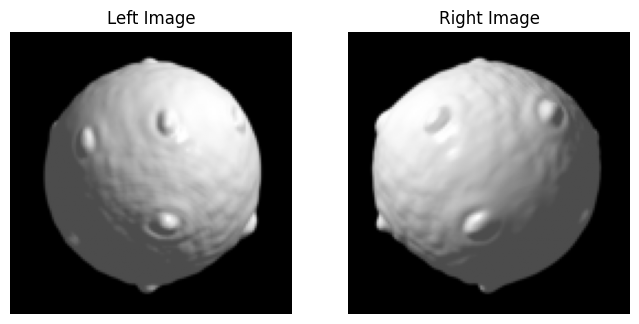

In [2]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PollenDataset(image_transforms=image_transforms)

(left_img, right_img), points, rotation, name = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [5]:
(sample_images, points, rotation, name) = dataset[0]
front_tensor, side_tensor = sample_images  # Assume left = front view, right = side view

In [7]:
# Convert tensors to numpy arrays (images are 1024x1024)
front_np = front_tensor.squeeze(0).numpy()
side_np = side_tensor.squeeze(0).numpy()

# Create binary masks: any nonzero pixel is considered part of the object.
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define the volume dimensions (cubic volume, size from image dimensions)
H, W = front_bin.shape  # (1024, 1024)
D = W  # depth = width, i.e., 1024

# Extrude the front silhouette along the z-axis.
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis.
# The side view corresponds to (z, y); insert an axis for x and repeat.
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the visual hull as the voxel-wise intersection.
visual_hull = np.logical_and(front_vol, side_vol)

# Downsample the volume for faster visualization if necessary.
# For instance, reduce by a factor of 8 (adjust step as needed).
step = 1
voxel_data = visual_hull[::step, ::step, ::step]

### 1. Load sample data and compute the reconstruction (visual hull)

In [8]:
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define volume dimensions – we assume a cubic volume.
H, W = front_bin.shape  # should be 1024 x 1024
D = W  # depth equal to width

# Extrude the front silhouette along the z-axis:
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis:
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the voxel-wise intersection (Visual Hull):
recon_volume = np.logical_and(front_vol, side_vol)
print("Reconstruction voxel volume shape:", recon_volume.shape)


Reconstruction voxel volume shape: (128, 128, 128)


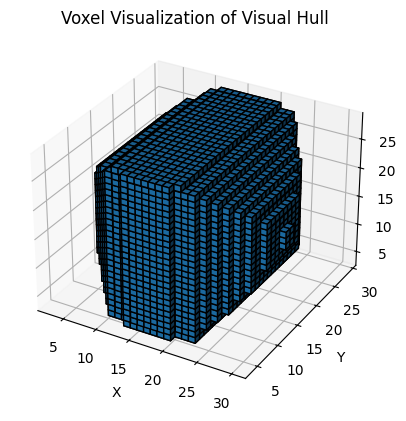

In [9]:
# simplify the voxels
step = 4
simplified_recon_volume = recon_volume[::step, ::step, ::step]

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(simplified_recon_volume, edgecolor='k')
ax.set_title("Voxel Visualization of Visual Hull")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [10]:
from scipy.ndimage import rotate

def iou3d(vol1, vol2):
    intersection = np.logical_and(vol1, vol2)
    union = np.logical_or(vol1, vol2)
    return np.sum(intersection) / np.sum(union)

def rotate_voxel_grid(voxel_grid, angle_x=0, angle_y=0, angle_z=0):
    """
    Rotate a 3D voxel occupancy grid about the x, y, and z axes.
    
    Parameters:
    - voxel_grid: 3D numpy array of booleans where True indicates an occupied voxel.
    - angle_x: Rotation angle (in degrees) around the x-axis (applied in the (y, z) plane).
    - angle_y: Rotation angle (in degrees) around the y-axis (applied in the (x, z) plane).
    - angle_z: Rotation angle (in degrees) around the z-axis (applied in the (x, y) plane).
    
    Returns:
    - A new 3D numpy array representing the rotated voxel grid.
    """
    # Rotate around the x-axis (rotate in the (y, z) plane)
    rotated = rotate(voxel_grid, angle=angle_x, axes=(1, 2),
                     reshape=True, order=0, mode='constant', cval=False)
    # Rotate around the y-axis (rotate in the (x, z) plane)
    rotated = rotate(rotated, angle=angle_y, axes=(0, 2),
                     reshape=True, order=0, mode='constant', cval=False)
    # Rotate around the z-axis (rotate in the (x, y) plane)
    rotated = rotate(rotated, angle=angle_z, axes=(0, 1),
                     reshape=True, order=0, mode='constant', cval=False)
    
    return rotated

recon_volume_rotated = rotate_voxel_grid(recon_volume, -rotation[0], -rotation[1], -rotation[2])

TODO: Normalized Surface Distance?

In [11]:
# models/visual_hull.py
import torch
import numpy as np
import lightning.pytorch as pl

class VisualHull(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self, front_tensor: torch.Tensor, side_tensor: torch.Tensor, step: int = 1) -> np.ndarray:
        front_np = front_tensor.squeeze().detach().cpu().numpy()
        side_np = side_tensor.squeeze().detach().cpu().numpy()
    
        front_bin = (front_np > 0).astype(np.uint8)
        side_bin = (side_np > 0).astype(np.uint8)
        
        print(front_bin.shape)
        
        H, W = front_bin.shape
        D = W

        front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)
        side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)
        visual_hull = np.logical_and(front_vol, side_vol)
        voxel_data = visual_hull[::step, ::step, ::step]
        
        return voxel_data

    def training_step(self, batch, batch_idx):
        (left_image, right_image), _, rotations, _ = batch
        _ = self.forward(left_image, right_image)
        loss = self.dummy_param * 0.0
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        (left_image, right_image), _, rotations, _ = batch
        voxel_data = self.forward(left_image, right_image)
        # For instance, log the voxel count as an evaluation metric.
        voxel_count = float(voxel_data.sum())
        self.log("val_voxel_count", voxel_count, prog_bar=True)
        loss = self.dummy_param * 0.0
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [2]:
# voxelise_gt.py  (patched)

import json, numpy as np, trimesh
from pathlib import Path
from trimesh.transformations import euler_matrix, translation_matrix, scale_matrix

def mesh_to_voxel(mesh_path, meta_path, res=128, fill=True):
    mesh = trimesh.load_mesh(mesh_path, process=False)
    meta = json.loads(Path(meta_path).read_text())

    # 1) replay the rotation used at render‑time
    rx, ry, rz = np.deg2rad(meta["rotation_deg"])
    center     = np.asarray(meta["center"])
    M_rot = (translation_matrix(center) @
             euler_matrix(rx, ry, rz, axes="sxyz") @
             translation_matrix(-center))
    mesh.apply_transform(M_rot)

    # 2) world units -> voxel units (64 / parallelScale)
    scale_cam = meta["camera_front"]["parallel_scale"]
    S = scale_matrix((res / 2) / scale_cam)
    O = translation_matrix([res/2]*3)
    mesh.apply_transform(O @ S)

    # 3) voxelise at pitch = 1
    vox = mesh.voxelized(pitch=1, method="subdivide")
    if fill:
        vox = vox.fill()

    idx = vox.sparse_indices      # shape (n,3), order X Y Z

    # reorder to Y X Z so we can index occ[Y, X, Z]
    idx = idx[:, (1, 0, 2)]

    occ = np.zeros((res, res, res), dtype=bool)
    mask = np.all((idx >= 0) & (idx < res), axis=1)
    occ[tuple(idx[mask].T)] = True
    return occ


In [3]:
import numpy as np

gt_occ = mesh_to_voxel(
    "data/processed/meshes/17767_Common_knapweed_Centaurea_nigra_pollen_grain.stl",
    "data/processed/images/metadata/17767_Common_knapweed_Centaurea_nigra_pollen_grain_cam.json",
    res=128
)

In [14]:
from core.models import VisualHull

vh = VisualHull()

(left, right), points, rotation, name = dataset[0]

In [15]:
pred_occ = vh(left.unsqueeze(0), right.unsqueeze(0))

In [16]:
iou = np.logical_and(pred_occ, gt_occ).sum() / np.logical_or (pred_occ, gt_occ).sum()
print("IoU =", iou)

IoU = 0.5066185276996351


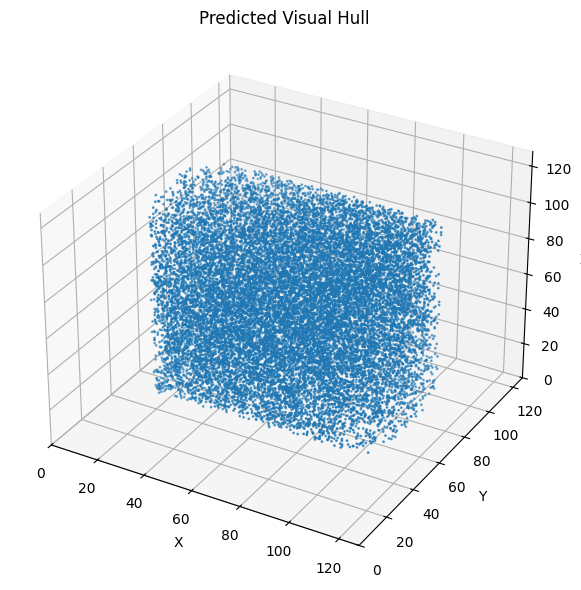

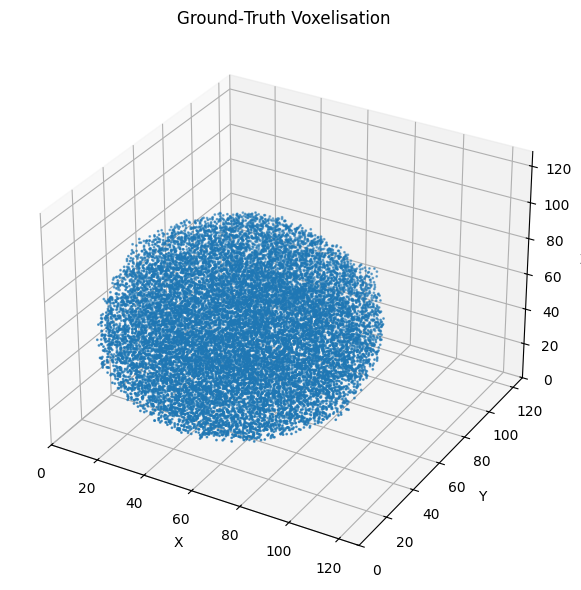

In [17]:
def plot_voxel_grid(occ, title, max_points=20000):
    """
    Visualise a sparse voxel grid with a 3‑D scatter.
    
    Parameters
    ----------
    occ : (N,N,N) bool
        Occupancy tensor.
    title : str
        Title for the plot.
    max_points : int
        Plot at most this many voxels for speed; random sample if needed.
    """
    coords = np.argwhere(occ)
    if coords.shape[0] > max_points:
        idx = np.random.choice(coords.shape[0], max_points, replace=False)
        coords = coords[idx]

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 1], coords[:, 0], coords[:, 2], s=1) # X<->Y swap for nicer view
    ax.set_title(title)
    ax.set_xlim(0, occ.shape[1])
    ax.set_ylim(0, occ.shape[0])
    ax.set_zlim(0, occ.shape[2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()

# Create the two plots (separate figures as requested)
plot_voxel_grid(pred_occ[0], "Predicted Visual Hull")
plot_voxel_grid(gt_occ,   "Ground‑Truth Voxelisation")

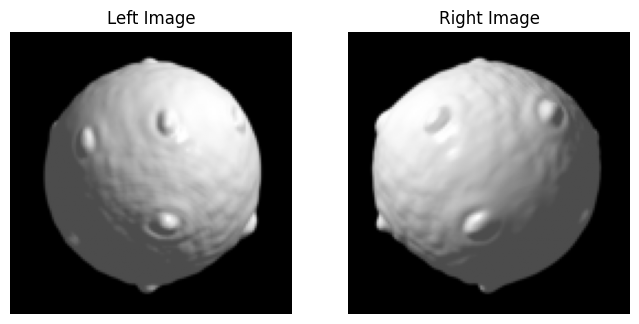

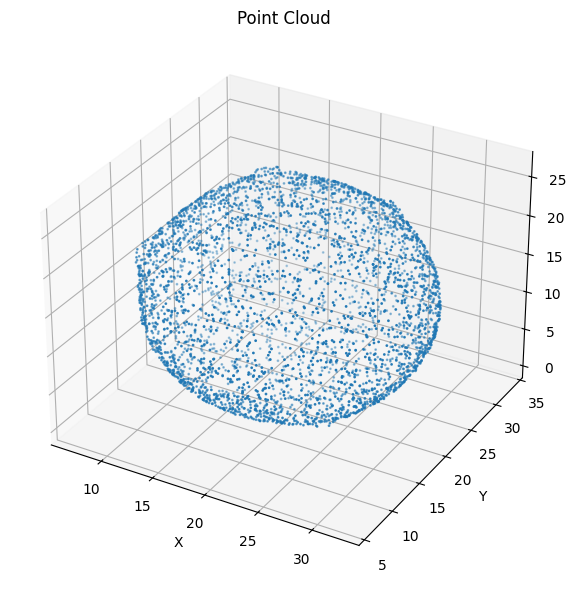

In [18]:
# Plot the images
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left.squeeze(), cmap='gray')
plt.title("Left Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(right.squeeze(), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

# Plot the point cloud
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=1)
ax.set_title("Point Cloud")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.tight_layout()
plt.show()

In [2]:
voxel = torch.load("data/processed/voxels/17767_Common_knapweed_Centaurea_nigra_pollen_grain.pt")

In [4]:
import trimesh

voxel_np = voxel.detach().cpu().numpy()
occupancy = voxel_np.astype(bool)
voxel_grid = trimesh.voxel.VoxelGrid(occupancy)


In [5]:
voxel.shape

torch.Size([128, 128, 128])

In [6]:
voxel_grid.show()